In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import scipy
from dateutil.relativedelta import relativedelta
import MH4518.WY.Utils.constants as cs
import MH4518.WY.Utils.Dates as dates 
import MH4518.WY.Utils.payoff as pf
import MH4518.WY.Utils.GBM as gbm
import MH4518.WY.Utils.ProductPrice as pp 

import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp
import pandas as pd
import logging


In [2]:
def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

[*********************100%***********************]  2 of 2 completed


In [9]:
sim_data = gbm.multi_asset_gbm_n_sims(plot= False, plotasset=False, nsims= 1000, data = data, fdos = cs.initial_fixing_date)
lonza_path = sim_data['LONN.SW']
sika_path = sim_data['SIKA.SW']
params = {
      # days
    'Denomination': 1000,   # currency units
    'Coupon_Rate': 0.08/4     # 5% annual coupon
}

Length of date_list: 315
Number of time steps (num_steps): 315


In [10]:
pf.payoff(lonza_path, sika_path, params, cs.initial_fixing_date)

array([1100.        , 1100.        , 1084.34435183, 1100.        ,
       1046.40660934, 1067.77110749, 1100.        , 1100.        ,
       1096.77402301, 1100.        , 1100.        , 1093.21440209,
       1100.        , 1100.        , 1100.        , 1087.13023676,
       1087.26834434, 1100.        , 1100.        , 1091.57487964,
       1084.57214786, 1100.        , 1100.        , 1081.30557109,
       1089.72085773, 1089.39240335, 1100.        , 1100.        ,
       1100.        , 1078.35730136, 1100.        , 1088.53477872,
       1093.5288801 , 1100.        , 1100.        , 1080.56536063,
       1097.35747894, 1082.96016304, 1100.        , 1100.        ,
       1100.        , 1100.        , 1100.        , 1100.        ,
       1100.        , 1079.90498429, 1082.92351272, 1100.        ,
       1100.        , 1063.57902881, 1066.52464671, 1100.        ,
       1100.        , 1100.        , 1100.        , 1100.        ,
       1100.        , 1084.50748938, 1053.93845821, 1100.     

In [5]:
def payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset='Lonza', direction=0):
    """
    Calculates the payoff for each simulation based on the product conditions with perturbations.
    
    Params:
        paths1: DataFrame of simulated paths for Lonza (columns: simulations)
        paths2: DataFrame of simulated paths for Sika (columns: simulations)
        params: Dictionary containing product parameters
        fdos: First date of simulation (pricing date)
        h: Perturbation factor
        perturb_asset: The asset to perturb ('Lonza' or 'Sika')
        direction: Perturbation direction (-1 for down, 1 for up, 0 for base)
    
    Returns:
        payoffs: Array of payoffs for each simulation
    """
    
    
    perturbed_paths1 = paths1.copy()
    perturbed_paths2 = paths2.copy()
    
    # Apply perturbation
    if perturb_asset == 'Lonza':
        perturbed_paths1 = paths1 * (1 + direction * h)
    elif perturb_asset == 'Sika':
        perturbed_paths2 = paths2 * (1 + direction * h)
    else:
        raise ValueError("perturb_asset must be 'Lonza' or 'Sika'")
    
    
    payoffs = pf.payoff(perturbed_paths1, perturbed_paths2, params, fdos)
    return payoffs
def delta(price_arr, h):
    return (price_arr[1] - price_arr[2]) / (2 * h * price_arr[0])

def gamma(price_arr, h):
    return (price_arr[1] - 2 * price_arr[0] + price_arr[2]) / (price_arr[0] * (h ** 2))

# Define Greek calculation functions
def calculate_greeks(paths1, paths2, params, fdos, h, perturb_asset='Lonza'):
    P_base = pf.payoff(paths1, paths2, params, fdos)
    P_up = payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset, direction=1)
    P_down = payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset, direction=-1)
    deltas = delta([P_base, P_up, P_down], h)
    gammas = gamma([P_base, P_up, P_down], h)
    return deltas, gammas

def calculate_greeks_multi_asset(paths1, paths2, params, fdos, h, perturb_assets=['Lonza', 'Sika']):
    greeks_dict = {}
    for asset in perturb_assets:
        deltas, gammas = calculate_greeks(paths1, paths2, params, fdos, h, perturb_asset=asset)
        greeks_dict[asset] = {'Delta': deltas, 'Gamma': gammas}
    return greeks_dict

# Simulation Parameters
h = 0.01  # 1%
perturb_assets = ['Lonza', 'Sika']
params = {
    'Settlement_Delay': 2,  # days
    'Denomination': 1000,   # currency units
    'Coupon_Rate': 0.08/4     # 5% annual coupon
}

In [11]:
# Calculate Greeks for multiple assets
greeks = calculate_greeks_multi_asset(lonza_path, sika_path, params, cs.initial_fixing_date, h, perturb_assets=perturb_assets)



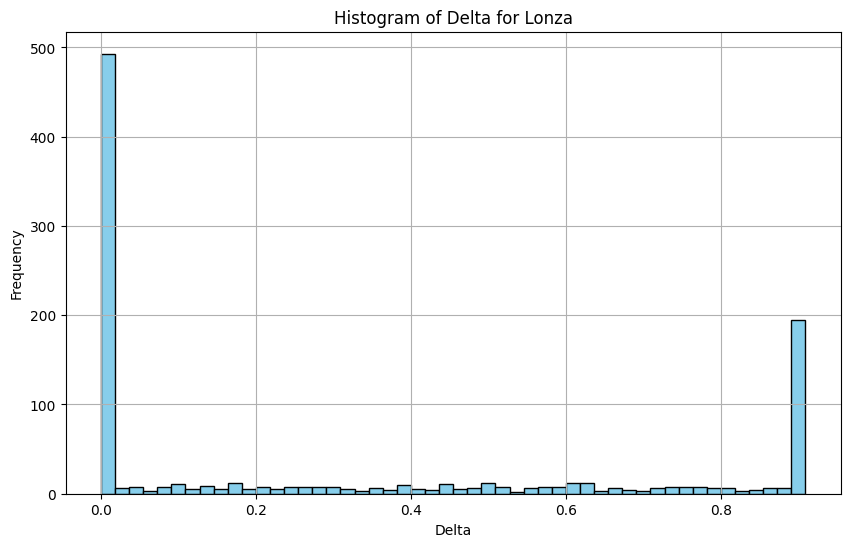

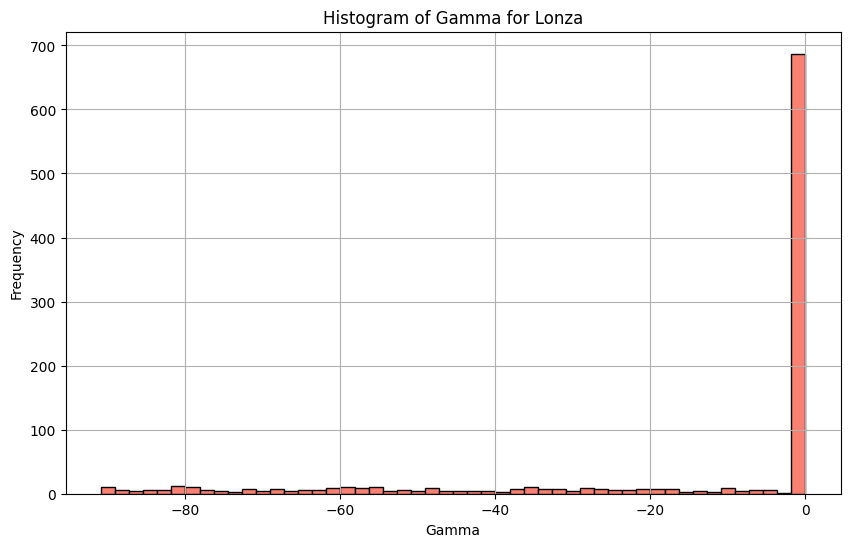

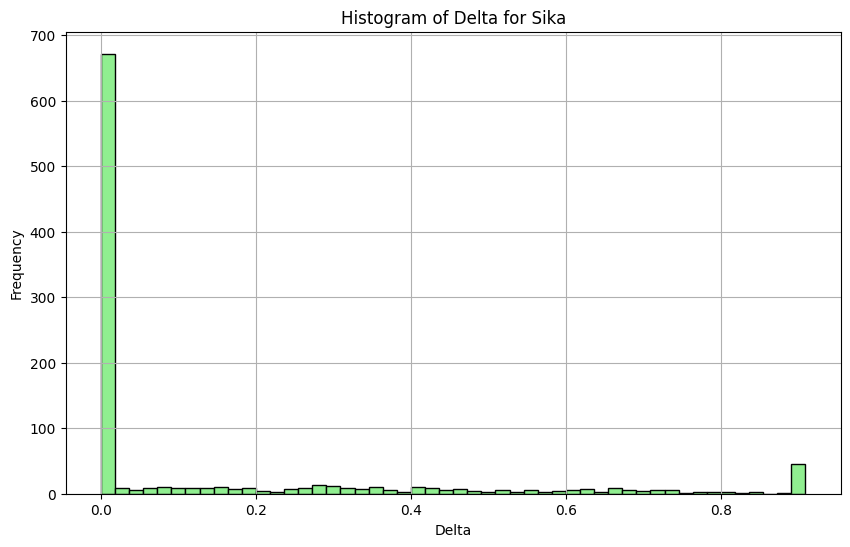

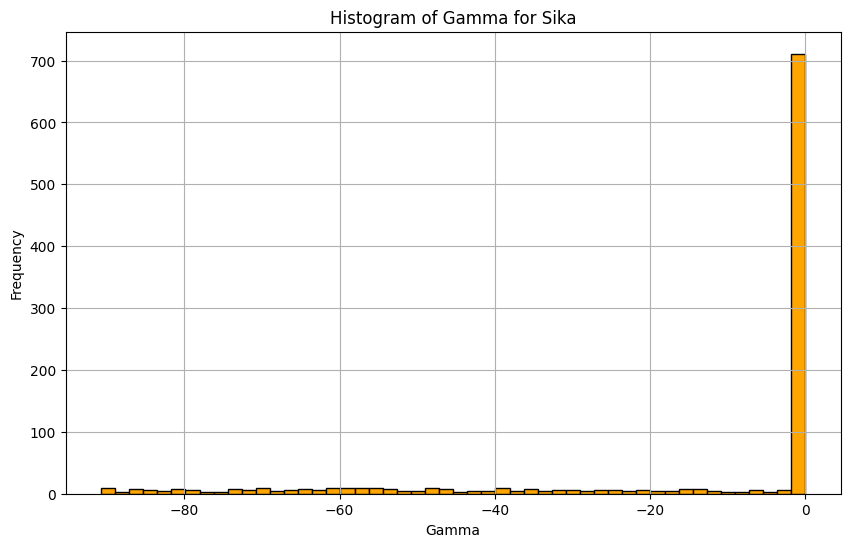

In [12]:
# Access delta and gamma for Lonza
delta_lonza = greeks['Lonza']['Delta']
gamma_lonza = greeks['Lonza']['Gamma']

# Access delta and gamma for Sika
delta_sika = greeks['Sika']['Delta']
gamma_sika = greeks['Sika']['Gamma']

# Visualize Delta and Gamma for Lonza
plt.figure(figsize=(10, 6))
plt.hist(delta_lonza, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Delta for Lonza')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(gamma_lonza, bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of Gamma for Lonza')
plt.xlabel('Gamma')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualize Delta and Gamma for Sika
plt.figure(figsize=(10, 6))
plt.hist(delta_sika, bins=50, color='lightgreen', edgecolor='black')
plt.title('Histogram of Delta for Sika')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(gamma_sika, bins=50, color='orange', edgecolor='black')
plt.title('Histogram of Gamma for Sika')
plt.xlabel('Gamma')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Calibration successful: {'a': np.float64(0.10826990922393587), 'b': np.float64(0.06695567691237256), 'sigma': np.float64(0.008832060537589417)}
